<a href="https://colab.research.google.com/github/bscot/Broadband_tomography_with_CASTOR_and_SPEHREx/blob/main/Copy_of_TLM_redshift_and_color_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib==0.4.16
!pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
698211
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [21]:
cd /content/drive/MyDrive/Research/CASTORpz


/content/drive/MyDrive/Research/CASTORpz


In [22]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [23]:
names_phot = ["ID", "photoz",
              "LSST_u_MAG",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]

Roman_os = ["Roman-only", "Roman+CASTOR", "Roman+Euclid+LSST+CASTOR", "Roman+LSST"]

available_os = available_os + Roman_os
print(available_os)

names = available_os

['CASTOR-only', 'LSST-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Euclid+LSST', 'Euclid+LSST+CASTOR', 'Roman-only', 'Roman+CASTOR', 'Roman+Euclid+LSST+CASTOR', 'Roman+LSST']


In [24]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [25]:
available_os = ['LSST-only',
                'CASTOR-only',
                'Euclid+LSST',
                'LSST+CASTOR',
                'Roman+Euclid+LSST',
                'Roman+Euclid+LSST+CASTOR']

os_combo_labels = {'LSST-only': 'LSST',
                  'CASTOR-only': 'CASTOR',
                  'LSST+CASTOR': 'LSST+CASTOR',
                  'Roman+LSST': 'LSST+Roman',
                  # 'Roman+LSST+CASTOR' : 'LSST+Roman+CASTOR', #(currently training, will be in Mar_experiments)
                  'Roman+Euclid+LSST': 'LSST+Roman+Euclid',
                  'Roman+Euclid+LSST+CASTOR': 'LSST+Roman+Euclid+CASTOR'}

In [26]:
# tav_cats = {}
# just_tav = {}
# for os in available_os:
#   # print(os)
#   with (open(f"{os}_with_tav.pkl", 'rb')) as openfile:
#     tav_cats[os] = pd.read_pickle(openfile)
#     # print(tav_cats[os].columns)
#     just_tav[os] = tav_cats[os]['log_prob']

In [27]:
# [(tav_cats['LSST-only']['z_true'] > 1.5) & (tav_cats['LSST-only']['z_true'] < 2.25)]

In [28]:
# just_tav['LSST-only'][(tav_cats['LSST-only']['z_true'] > 1.5) & (tav_cats['LSST-only']['z_true'] < 2.25) & tav_cats['LSST-only']['z_true'] < 2.25)]

In [29]:
# u-band cuts on just_tav - 30, 38, 45 second exposures
# distribution of these values
# plot the CDF


In [30]:
# ls reruns_of_old_catalogs/

In [31]:
# flows = FlowEnsemble(file=f"reruns_of_old_catalogs/pzflow_ensemble_for_LSST-only_z15to225.pkl")

In [32]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')
CASTOR_baseline = Table.from_pandas(mock_cat)

In [33]:
# put data in expected format for TLM

LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [41]:
which_cols = {}
which_cols['LSST'] = {'r': LSST_r_mag,
                             'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'z-y': LSST_z_mag - LSST_y_mag,
                      }
which_cols['CASTOR'] = {'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag}
which_cols['Roman'] = {'106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag}
which_cols['Euclid'] = { 'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag}

In [42]:
test_catalogs = {}
test_catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+Roman'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR-any'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()

In [43]:
LSST_mask = (LSST_u_mag < 25.6) & (LSST_g_mag < 26.9) & (LSST_r_mag < 26.9) & (LSST_i_mag < 26.4) & (LSST_z_mag < 25.6) & (LSST_y_mag < 24.8) #https://www.lsst.org/scientists/keynumbers
CASTOR_mask = (CASTOR_g_mag < 27.5) & (CASTOR_u_mag < 27.5) & (CASTOR_uv_mag < 27.6)
Roman_mask = (Roman_106_mag < 26.7) & (Roman_129_mag < 26.7) & (Roman_158_mag < 26.7) & (Roman_184_mag < 26.7) # https://www.stsci.edu/roman/surveys-and-programs
Euclid_mask = (Euclid_VIS_mag < 26.2) & (Euclid_J_mag < 24.5) & (Euclid_H_mag < 24.5) & (Euclid_Y_mag < 24.5) #https://arxiv.org/pdf/2108.01201

masks = {}

masks['LSST-only'] = LSST_mask
masks['CASTOR-only'] = CASTOR_mask
masks['Roman-only'] = Roman_mask
masks['Euclid-only'] = Euclid_mask

masks['LSST+CASTOR'] = LSST_mask & CASTOR_mask
masks['Euclid+CASTOR'] = Euclid_mask & CASTOR_mask
masks['Roman+CASTOR'] = Roman_mask & CASTOR_mask
masks['Euclid+LSST'] = Euclid_mask & LSST_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Euclid+LSST+CASTOR'] = Euclid_mask & LSST_mask & CASTOR_mask

masks['Roman+Euclid+LSST+CASTOR'] = Roman_mask & Euclid_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+CASTOR'] = Roman_mask & Euclid_mask & CASTOR_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Roman+Euclid+LSST'] = Roman_mask & Euclid_mask & LSST_mask
masks['Euclid+Roman'] = Euclid_mask & Roman_mask

masks['Roman+LSST+CASTOR'] = Roman_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+LSST+CASTOR-any'] = Roman_mask + LSST_mask + Euclid_mask + CASTOR_mask

In [44]:
import scipy.stats as stats

In [45]:
catalogs = test_catalogs
available_os = list(test_catalogs.keys())

# available_os = ['LSST-only',
#                 'Roman-only',
#                 'CASTOR-only',
#                 'Euclid-only',
#                 'Euclid+Roman',
#                 'Roman+Euclid+LSST+CASTOR',
#                 'LSST+CASTOR',
#                 'Euclid+LSST']


# # for os in available_os:
# #   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks[os]]

# catalogs = test_catalogs

# for os in available_os:
#   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks['Roman+Euclid+LSST+CASTOR-any']]

# false_mask = np.full(len(catalogs['LSST-only'][masks['Roman+Euclid+LSST+CASTOR']]), False)
# false_mask[0:90000] = True

# np.random.shuffle(false_mask)

for os in available_os:
  print(os)
  # catalogs[os] = catalogs[os][masks['Roman+Euclid+LSST+CASTOR']][false_mask]
  catalogs[os] = catalogs[os][masks[os]]
  catalogs[os] = catalogs[os][(np.abs(stats.zscore(catalogs[os])) < 5).all(axis=1)]

LSST-only
CASTOR-only
Roman-only
Euclid-only
LSST+CASTOR
Euclid+CASTOR
Roman+CASTOR
Euclid+LSST
Roman+LSST
Euclid+Roman
Roman+LSST+CASTOR
Roman+Euclid+CASTOR
Euclid+LSST+CASTOR
Roman+Euclid+LSST
Roman+Euclid+LSST+CASTOR
Roman+Euclid+LSST+CASTOR-any


In [46]:
available_os = list(test_catalogs.keys())

flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"June_12_runs/pzflow_ensemble_for_{os}.pkl")

In [22]:
# from scipy import stats

In [23]:
# catalogs = {}

# for os in available_os:
#   catalogs[os] = test_catalogs[os][(np.abs(stats.zscore(test_catalogs[os])) < 3).all(axis=1)]

In [99]:
tav = {}
for os in available_os:
  print(os)
  tav[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

LSST-only
CASTOR-only
Roman-only
Euclid-only
LSST+CASTOR
Euclid+CASTOR
Roman+CASTOR
Euclid+LSST
Roman+LSST
Euclid+Roman
Roman+LSST+CASTOR
Roman+Euclid+CASTOR
Euclid+LSST+CASTOR
Roman+Euclid+LSST
Roman+Euclid+LSST+CASTOR
Roman+Euclid+LSST+CASTOR-any


In [ ]:
np.sum(tav['Euclid+LSST']<-1000)

Array(0, dtype=int32)

In [29]:
tav[os].mean(axis=1)

Array([ 0.6653145 ,  0.01611122,  2.6179688 , ..., -0.05171123,
        1.066002  ,  0.32209414], dtype=float32)

In [ ]:
# mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')

# CASTOR_baseline = Table.from_pandas(mock_cat[(mock_cat["Euclid_VIS_MAG"] <= 24.5) & (mock_cat["LSST_r_MAG"] >= 17.5)]) # apply magnitude limit cuts
# CASTOR_baseline = Table.from_pandas(mock_cat) # apply magnitude limit cuts

In [ ]:
# # put data in expected format for TLM

# LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
# LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
# LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
# LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
# LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
# LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")


# # LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# # LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# # LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# # LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

# CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
# CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
# CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# # CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# # CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# # CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

# Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
# Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
# Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
# Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# # Roman - only a subset of the Roman filters are available?

# # Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# # Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
# Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

# Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# # Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
# Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

# Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# # Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

# ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
# z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [ ]:
# # get magnitudes and set up the catalogs

# catalogs = dict()
# catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                               'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                               'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs["Roman+Euclid+LSST+CASTOR"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag,
#                              '106': Roman_106_mag,
#                              '129 - 106': Roman_129_mag - Roman_106_mag,
#                              '158-129': Roman_158_mag - Roman_129_mag,
#                              '184-158': Roman_184_mag - Roman_158_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs["Roman+Euclid+LSST"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              '106': Roman_106_mag,
#                              '129 - 106': Roman_129_mag - Roman_106_mag,
#                              '158-129': Roman_158_mag - Roman_129_mag,
#                              '184-158': Roman_184_mag - Roman_158_mag
#                       }).set_index('CASTOR_ID').dropna()

In [ ]:

# available_os = ['LSST-only',
#                 'CASTOR-only',
#                 'Euclid+LSST',
#                 'LSST+CASTOR',
#                 'Roman+Euclid+LSST',
#                 'Roman+Euclid+LSST+CASTOR']

# tav = {}
# for os in available_os:
#   tav[os] = flows[os].log_prob(catalogs[os])

In [ ]:
# tav[]

**Dropping bad flows here**

In [ ]:
losses = {}
for os in available_os:
  with (open(f"losses_for_{os}.pkl", 'rb')) as openfile:
    losses[os] = pd.read_pickle(openfile)

In [ ]:
flow_list = list(np.linspace(0, 29, 30).astype(int))
bad_flows = {}

for os in available_os:
  bad_flows_list = []
  for flow in flow_list:
    if np.sum(np.isinf(np.array(losses[os]['losses'][f"Flow {flow}"]))) > 0:
      bad_flows_list.append(flow)
    bad_flows[os] = bad_flows_list

In [ ]:
bad_flows

{'LSST-only': [8, 17, 20],
 'CASTOR-only': [3, 13, 16],
 'Euclid+LSST': [2, 8, 9, 13],
 'LSST+CASTOR': [25, 28],
 'Roman+Euclid+LSST': [2, 5, 14, 16, 19],
 'Roman+Euclid+LSST+CASTOR': [7, 15]}

In [ ]:
just_tav_ensemble = {}
for os in available_os:
  just_tav_ensemble[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

In [ ]:
new_tav = {}

for os in available_os:
  new_tav[os] = np.delete(just_tav_ensemble[os], bad_flows[os], axis = 1)

In [ ]:
for os in available_os:
  print(new_tav[os].shape)

(108330, 27)
(108330, 27)
(108330, 26)
(108330, 28)
(108330, 25)
(108330, 28)


**Redshift Binned Plots**

In [23]:
import scipy.stats as sps

In [53]:
available_os = ['LSST-only',
                'Roman-only',
                'CASTOR-only',
                'Euclid-only',
                'Euclid+Roman',
                'Roman+Euclid+LSST+CASTOR',
                'LSST+CASTOR',
                'Euclid+LSST',
                'Euclid-only']

In [54]:
def compute_milb(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [55]:
# entropy term

def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  # for os in available_os:
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]

      # print(catalogs[os].columns)

      # print('shape is: ')

      # print(np.shape(catalogs[os]))

    print(all_tlm[os])
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      print(zmax)
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(subset['logprob'])
      # mean = np.mean(vals[vals >   -3])
      # print(mean)
      # std = np.std(vals[vals > -3])
      std = np.std(subset['logprob'])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [ ]:
# (catalogs['LSST-only']['z_true'] <= zmax)
# catalogs['LSST-only']['z_true']

In [ ]:
# zmin = 0.03
# zmax = 1
# print(catalogs['LSST-only'][(catalogs['LSST-only']['z_true'] <= zmax)]) # & (catalogs['LSST-only']['z_true'] < zmax)])
# print(catalogs['LSST-only'][(catalogs['LSST-only']['z_true'] >= zmin) & (catalogs['LSST-only']['z_true'] < zmax)])

In [ ]:
# available_os = ['LSST-only', 'Roman+Euclid+LSST+CASTOR-any']

In [56]:
all_tlm, is_inf_mask = compute_milb(tav, available_os)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

['LSST-only', 'Roman-only', 'CASTOR-only', 'Euclid-only', 'Euclid+Roman', 'Roman+Euclid+LSST+CASTOR', 'LSST+CASTOR', 'Euclid+LSST', 'Euclid-only']


<ipython-input-54-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


LSST-only
[ 3.9986796  1.1687522  2.6655364 ...  3.5858457  0.6270231 -0.6633512]
0.030303030303030304
0.06060606060606061
0.09090909090909091
0.12121212121212122
0.15151515151515152
0.18181818181818182
0.21212121212121213
0.24242424242424243
0.2727272727272727
0.30303030303030304
0.33333333333333337
0.36363636363636365
0.3939393939393939
0.42424242424242425
0.4545454545454546
0.48484848484848486
0.5151515151515151
0.5454545454545454
0.5757575757575758
0.6060606060606061
0.6363636363636364
0.6666666666666667
0.696969696969697
0.7272727272727273
0.7575757575757576
0.7878787878787878
0.8181818181818182
0.8484848484848485
0.8787878787878788
0.9090909090909092
0.9393939393939394
0.9696969696969697
1.0
1.0303030303030303
1.0606060606060606
1.0909090909090908
1.1212121212121213
1.1515151515151516
1.1818181818181819
1.2121212121212122
1.2424242424242424
1.2727272727272727
1.303030303030303
1.3333333333333335
1.3636363636363638
1.393939393939394
1.4242424242424243
1.4545454545454546
1.48484848

In [57]:
def compute_milb_ensemble(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = all_milb[os] + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    # all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [58]:
all_tlm, is_inf_mask = compute_milb_ensemble(tav, available_os)

epistemic_variance = {}

for os in available_os:
  epistemic_variance[os] = all_tlm[os].std(axis=1)
  redshifts[os] = catalogs[os]['z_true']

binned_variance = {}

for os in available_os:
  print(epistemic_variance[os].shape)
  print(redshifts[os].shape)

  ploterr = np.empty_like(zbins)
  for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      ploterr[i] = np.mean(epistemic_variance[os][(redshifts[os] >=zmin) & (redshifts[os] < zmax)])

      binned_variance[os] = ploterr

['LSST-only', 'Roman-only', 'CASTOR-only', 'Euclid-only', 'Euclid+Roman', 'Roman+Euclid+LSST+CASTOR', 'LSST+CASTOR', 'Euclid+LSST', 'Euclid-only']


<ipython-input-57-2c69b1faeef8>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


(116127,)
(116127,)
(360862,)
(360862,)
(225481,)
(225481,)
(152739,)
(152739,)
(152240,)
(152240,)
(96690,)
(96690,)
(103610,)
(103610,)
(108057,)
(108057,)
(152739,)
(152739,)


LSST-only
0
-1.0256441732872812
Euclid-only
0
-0.18921197950839996
Roman-only
0
2.042e-320
CASTOR-only
0
-0.40575724840164185
LSST+CASTOR
0
0.14503388106822968
Euclid+Roman
0
6.78223697409725e-310
Euclid+LSST
0
1.848524808883667
Roman+Euclid+LSST+CASTOR
0
-0.01160120964050293


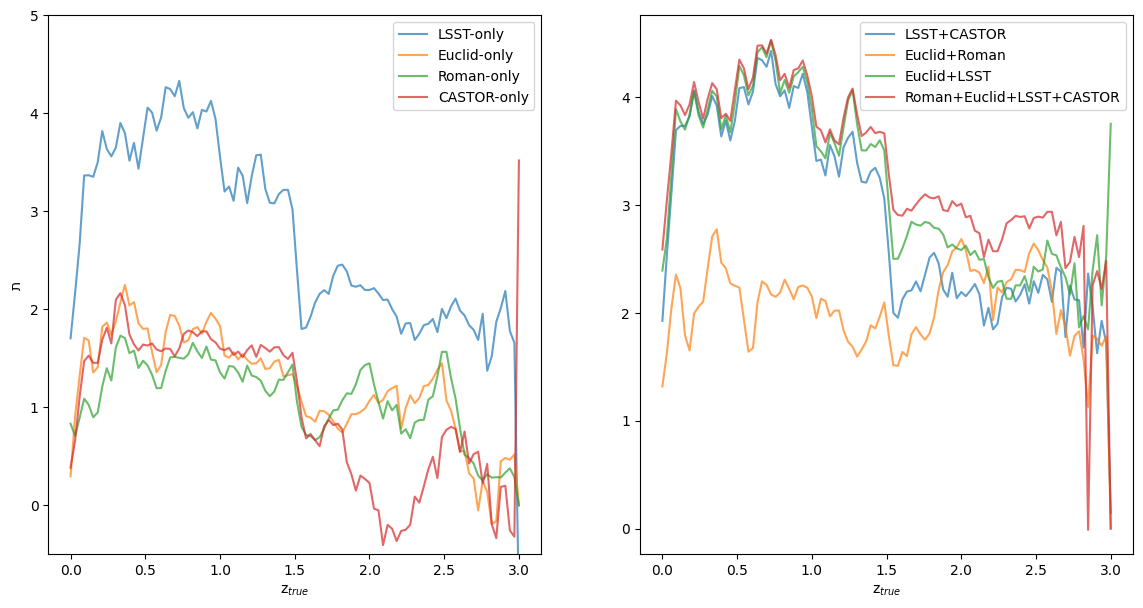

<Figure size 640x480 with 0 Axes>

In [62]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))

zbins = np.linspace(0, 3, 100)

plt_os_left = ['LSST-only',
               'Euclid-only',
               'Roman-only',
               'CASTOR-only']

plt_os_right = ['LSST+CASTOR',
          'Euclid+Roman',
          'Euclid+LSST',
          'Roman+Euclid+LSST+CASTOR']

for os in plt_os_left:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  # ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)
  # ax[2].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

for os in plt_os_right:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$')
ax[1].legend()
# ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
# ax[1].set_ylim(-0.5, 2)

# ax[2].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')
# ax[2].set_xlabel('z$_{true}$')
# ax[2].set_ylim(-0.5, 2)

# plt.savefig('redshift_binned_with_uncertainty_same_scales.png')
plt.show()

# ax[0].set_ylim(-2, 5)

plt.savefig('new_main_results_figure_711_2_panel.pdf')

LSST-only
0
-1.0256441732872812
Euclid-only
0
-0.18921197950839996
Roman-only
0
2.042e-320
CASTOR-only
0
-0.40575724840164185
LSST+CASTOR
0
0.14503388106822968
Euclid+Roman
0
6.78223697409725e-310
Euclid+LSST
0
1.848524808883667
Roman+Euclid+LSST+CASTOR
0
-0.01160120964050293


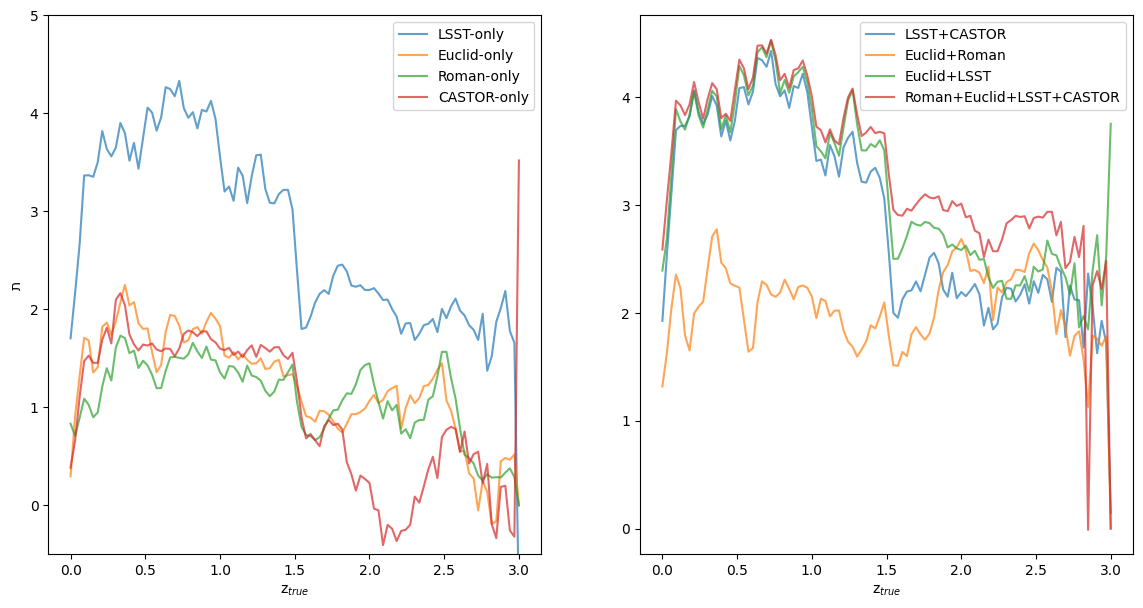

In [73]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))

zbins = np.linspace(0, 3, 100)

plt_os_left = ['LSST-only',
               'Euclid-only',
               'Roman-only',
               'CASTOR-only']

plt_os_right = ['LSST+CASTOR',
          'Euclid+Roman',
          'Euclid+LSST',
          'Roman+Euclid+LSST+CASTOR']

for os in plt_os_left:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  # ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)
  # ax[2].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

for os in plt_os_right:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$')
ax[1].legend()
# ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
# ax[1].set_ylim(-0.5, 2)

# ax[2].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')
# ax[2].set_xlabel('z$_{true}$')
# ax[2].set_ylim(-0.5, 2)

# plt.savefig('redshift_binned_with_uncertainty_same_scales.png')
# plt.show()

# ax[0].set_ylim(-2, 5)

plt.savefig('new_main_results_figure_711_2_panel.pdf')

LSST-only
0
-1.0256441732872812
Euclid-only
0
-0.18921197950839996
Roman-only
0
2.042e-320
CASTOR-only
0
-0.40575724840164185
LSST+CASTOR
0
0.14503388106822968
Euclid+Roman
0
6.78223697409725e-310
Euclid+LSST
0
1.848524808883667
Roman+Euclid+LSST+CASTOR
0
-0.01160120964050293


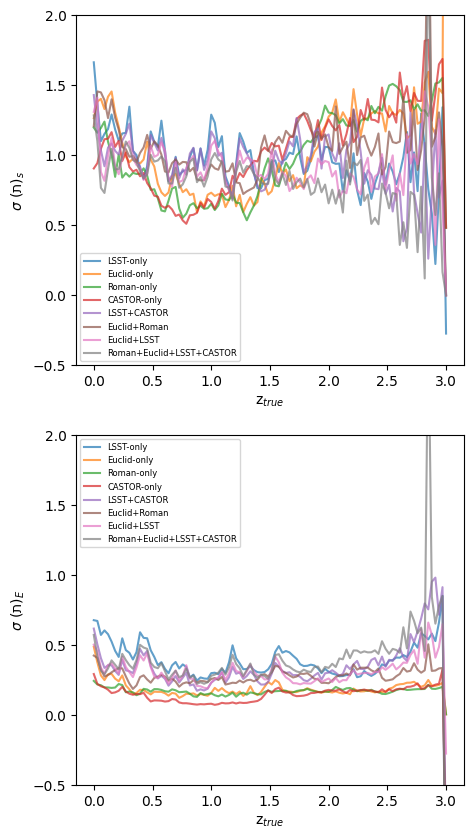

In [72]:
fig, ax = plt.subplots(2,1, figsize = (5, 10))

zbins = np.linspace(0, 3, 100)

plt_os = ['LSST-only',
               'Euclid-only',
               'Roman-only',
               'CASTOR-only',
               'LSST+CASTOR',
              'Euclid+Roman',
              'Euclid+LSST',
              'Roman+Euclid+LSST+CASTOR']

for os in plt_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  # ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[0].plot(zbins, errtav[os], label=os, alpha = 0.7)
  ax[1].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

# for os in plt_os_right:
#   print(os)
#   print(np.sum(np.isinf(avgtav[os])))
#   print(np.min(avgtav[os]))
#   ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 2)
ax[0].legend(fontsize=6)

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$')
ax[1].legend(fontsize=6)
ax[1].set_ylim(-0.5, 2)
ax[0].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
# ax[1].set_ylim(-0.5, 2)

ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')
# ax[2].set_xlabel('z$_{true}$')
# ax[2].set_ylim(-0.5, 2)

# plt.savefig('redshift_binned_with_uncertainty_same_scales.png')
# plt.show()

# ax[0].set_ylim(-2, 5)

plt.savefig('new_main_errors_figure_711_2_panel.pdf')

In [56]:
new_catalog[os]

,z_trueFalse,r,u-g,g-r,r-i,i-z,z-y,z_trueTrue,106,129 - 106,158-129,184-158
CASTOR_ID,,,,,,,,,,,,
3,0.2211,23.259175,0.388963,0.233539,0.022705,-0.005428,-0.064708,0.2211,23.319090,-0.029179,0.043581,-0.059506
12,0.7070,24.580852,-0.101902,0.256711,0.638455,0.055040,-0.005697,0.7070,23.878944,-0.143994,-0.148858,0.114864
73,0.4290,22.664345,0.406684,0.849034,0.207854,0.116569,0.161528,0.4290,22.094939,-0.099142,-0.014610,-0.023215
74,1.5087,23.744620,0.176465,0.068058,0.050240,-0.009388,0.407905,1.5087,23.147708,-0.162751,-0.075578,0.108841
85,1.0800,24.119466,0.148883,0.139313,0.230962,0.423380,0.217320,1.0800,23.113341,-0.001224,0.077282,-0.064753
...,...,...,...,...,...,...,...,...,...,...,...,...
964426,0.3230,23.775628,0.670550,0.738462,0.247866,0.226397,0.192344,0.3230,23.209816,-0.255409,-0.048224,-0.095337
964428,1.2587,23.131750,0.301321,0.215503,0.278632,0.447965,0.140599,1.2587,22.181332,-0.170479,-0.108815,-0.135983
964429,0.5593,23.418713,-0.136808,0.127887,0.138505,-0.061029,0.064696,0.5593,23.083740,0.028958,0.656884,0.057120


In [69]:
tav = {}

subset_catalogs = ['LSST-only', 'Roman+LSST', 'Euclid-only']
new_catalog = {}
for i,os in enumerate(subset_catalogs):
  print(os)
  new_catalog[os] = pd.merge(catalogs[subset_catalogs[i]], catalogs[subset_catalogs[i+1]], on='CASTOR_ID', how = 'inner').drop('z_true_y', axis=1).rename(columns={'z_true_x': 'z_true'})
  tav[os] = flows[os].log_prob(new_catalog[os], returnEnsemble = True)

LSST-only


KeyError: "None of [Index(['r', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y'], dtype='object')] are in the [columns]"

In [92]:
catalogs['LSST-only'].index

Index([     3,     12,     73,     74,     85,    104,    140,    141,    165,
          170,
       ...
       964420, 964421, 964422, 964423, 964424, 964426, 964428, 964429, 964439,
       964449],
      dtype='int64', name='CASTOR_ID', length=116127)

In [50]:
common_indices = catalogs['LSST+CASTOR'].index.intersection(catalogs['LSST-only'].index)
print(catalogs['LSST+CASTOR'].loc[common_indices])
print(catalogs['LSST-only'].loc[common_indices])

           z_true          r       u-g       g-r       r-i       i-z  \
CASTOR_ID                                                              
3          0.2211  23.259175  0.354974  0.233539  0.022705 -0.005428   
12         0.7070  24.580852  0.072682  0.256711  0.638455  0.055040   
73         0.4290  22.664345  0.443804  0.849034  0.207854  0.116569   
74         1.5087  23.744620  0.277857  0.068058  0.050240 -0.009388   
85         1.0800  24.119466  0.173584  0.139313  0.230962  0.423380   
...           ...        ...       ...       ...       ...       ...   
964426     0.3230  23.775628  0.693045  0.738462  0.247866  0.226397   
964428     1.2587  23.131750  0.391128  0.215503  0.278632  0.447965   
964429     0.5593  23.418713 -0.208110  0.127887  0.138505 -0.061029   
964439     0.3207  24.778841  0.380714  0.566495  0.228750  0.012524   
964449     0.3073  24.792897  0.234131  0.327416  0.276855 -0.096219   

                z-y          g      uv-u  
CASTOR_ID           

In [81]:
common_indices = catalogs['LSST+CASTOR'].index.intersection(catalogs['LSST-only'].index)

tav['LSST-only'] = flows['LSST-only'].log_prob(catalogs['LSST-only'].loc[common_indices], returnEnsemble = True)
tav['LSST+CASTOR'] = flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'].loc[common_indices], returnEnsemble = True)

In [86]:
common_indices = catalogs['Euclid+Roman'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True)
tav['Euclid+Roman'] = flows['Euclid+Roman'].log_prob(catalogs['Euclid+Roman'].loc[common_indices], returnEnsemble = True)

In [87]:
common_indices = catalogs['Euclid+CASTOR'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only2'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True) # this is where the bug is here, common_indices changes but tav['Euclid-only'] shouldn't for the next cell to work properly
tav['Euclid+CASTOR'] = flows['Euclid+CASTOR'].log_prob(catalogs['Euclid+CASTOR'].loc[common_indices], returnEnsemble = True)

In [93]:
import scipy.stats as sps

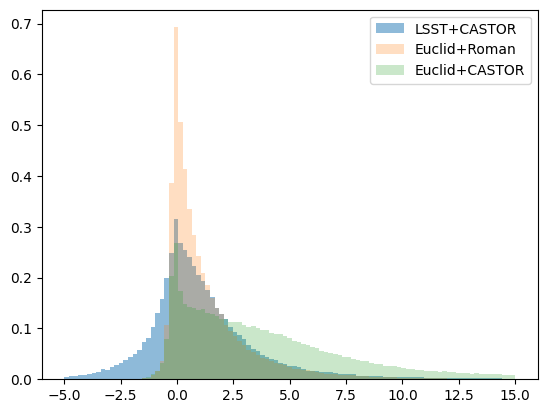

In [91]:
delta_tav_agg = []

delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

plt.hist(delta_tav_agg, alpha=0.5, density=True, bins=np.linspace(-5, 15, 100), label = 'LSST+CASTOR')

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

plt.hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+Roman')

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

plt.hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+CASTOR')

plt.legend()

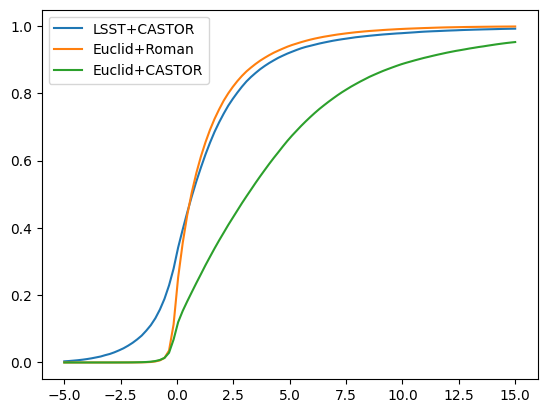

In [97]:
delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
plt.plot(xran, to_plot, label='LSST+CASTOR')

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
plt.plot(xran, to_plot, label='Euclid+Roman')

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
plt.plot(xran, to_plot, label='Euclid+CASTOR')

plt.legend()

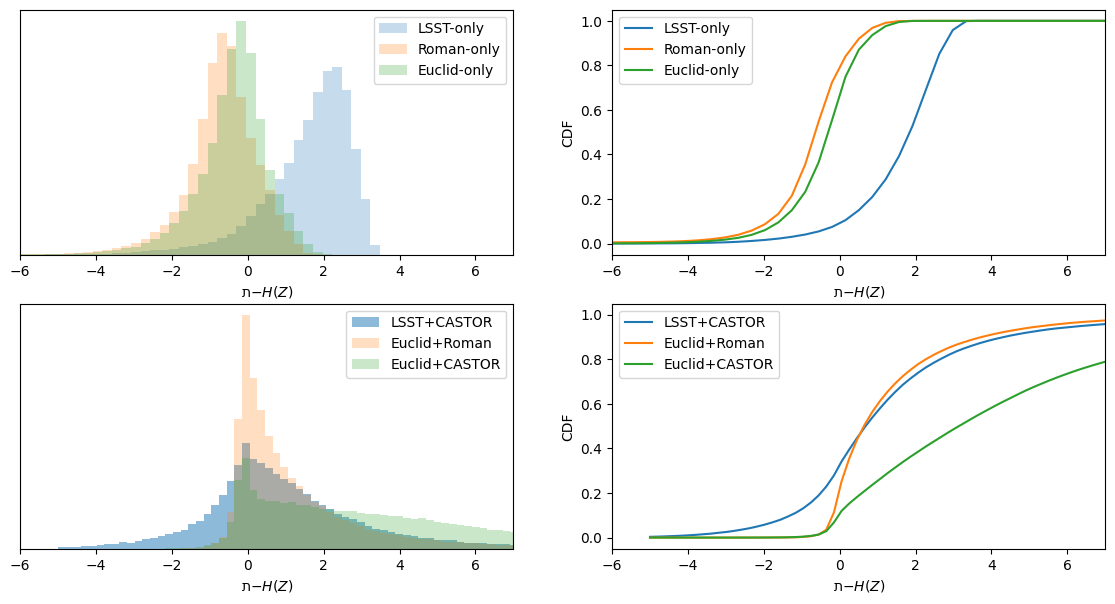

In [114]:
fig, ax = plt.subplots(2, 2, figsize=(14, 7))#, sharex=True)
delta_tav_agg = []
# which_plt = 0
# for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
#   ax[which_plt].hist(tav_cats[os]['z_true'], alpha=0.25, label=os[:-5], density=True, bins=100)
#   ax[which_plt].legend()
#   ax[which_plt].set_xlim(0, 5)
#   ax[which_plt].set_xlabel(r'$z$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   ax[which_plt].set_yticks([])

for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  ax[0,0].hist(tav[os].mean(axis=1), alpha=0.25, label=os, density=True, bins=np.linspace(-20, 5, 100))
  ax[0,0].legend()
  ax[0,0].set_xlim(-6, 7)
  ax[0,0].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  ax[0,0].set_yticks([])
which_plt = 1

for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  xran = np.linspace(-20, 15, 100)
  to_plot = sps.ecdf(tav[os].mean(axis=1)).cdf.evaluate(xran)
  ax[0,1].plot(xran, to_plot, label=os)
  ax[0,1].legend()
  ax[0,1].set_xlim(-6, 7)
  ax[0,1].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  # ax[which_plt].set_yticks([])
  ax[0,1].set_ylabel('CDF')

common_indices = catalogs['LSST+CASTOR'].index.intersection(catalogs['LSST-only'].index)

tav['LSST-only'] = flows['LSST-only'].log_prob(catalogs['LSST-only'].loc[common_indices], returnEnsemble = True)
tav['LSST+CASTOR'] = flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'].loc[common_indices], returnEnsemble = True)

common_indices = catalogs['Euclid+Roman'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True)
tav['Euclid+Roman'] = flows['Euclid+Roman'].log_prob(catalogs['Euclid+Roman'].loc[common_indices], returnEnsemble = True)

common_indices = catalogs['Euclid+CASTOR'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only2'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True) # this is where the bug is here, common_indices changes but tav['Euclid-only'] shouldn't for the next cell to work properly
tav['Euclid+CASTOR'] = flows['Euclid+CASTOR'].log_prob(catalogs['Euclid+CASTOR'].loc[common_indices], returnEnsemble = True)

delta_tav_agg = []

delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.5, density=True, bins=np.linspace(-5, 15, 100), label = 'LSST+CASTOR')

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+Roman')

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+CASTOR')

ax[1,0].legend()
ax[1,0].set_xlim(-6, 7)
ax[1,0].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
ax[1,0].set_yticks([])

delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='LSST+CASTOR')

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='Euclid+Roman')

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='Euclid+CASTOR')

ax[1,1].set_xlim(-6, 7)
ax[1,1].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# ax[which_plt].set_yticks([])
ax[1,1].set_ylabel('CDF')

ax[1,1].legend()

plt.savefig('new_figure_2_histograms.pdf')

#platypus

1. save and the load intermediate data products
2. clearly label the plots with their corresponding figures with the draft - text thing saying something clear and Big
3.

In [84]:
print(len(new_catalog)) # is all elements of LSST+CASTOR that also appear in LSST-only

print(len(catalogs['LSST-only']))
print(len(catalogs['LSST+CASTOR']))

103348
116127
103610


In [83]:
new_catalog

,z_true,r,u-g_x,g-r,r-i,i-z,z-y,u-g_y,g,uv-u
CASTOR_ID,,,,,,,,,,
3,0.2211,23.259175,0.388963,0.233539,0.022705,-0.005428,-0.064708,0.354974,23.519322,-0.081215
12,0.7070,24.580852,-0.101902,0.256711,0.638455,0.055040,-0.005697,0.072682,24.854984,0.274217
73,0.4290,22.664345,0.406684,0.849034,0.207854,0.116569,0.161528,0.443804,23.527045,0.540868
74,1.5087,23.744620,0.176465,0.068058,0.050240,-0.009388,0.407905,0.277857,23.811124,1.503954
85,1.0800,24.119466,0.148883,0.139313,0.230962,0.423380,0.217320,0.173584,24.258245,0.846885
...,...,...,...,...,...,...,...,...,...,...
964426,0.3230,23.775628,0.670550,0.738462,0.247866,0.226397,0.192344,0.693045,24.609589,0.701451
964428,1.2587,23.131750,0.301321,0.215503,0.278632,0.447965,0.140599,0.391128,23.334459,0.606193
964429,0.5593,23.418713,-0.136808,0.127887,0.138505,-0.061029,0.064696,-0.208110,23.572652,-0.067173


In [73]:
catalogs['LSST+CASTOR'] # this is a problem - need to fix this bug

,z_true,r,u-g,g-r,r-i,i-z,z-y,g,uv-u
CASTOR_ID,,,,,,,,,
3,0.2211,23.259175,0.354974,0.233539,0.022705,-0.005428,-0.064708,23.519322,-0.081215
12,0.7070,24.580852,0.072682,0.256711,0.638455,0.055040,-0.005697,24.854984,0.274217
73,0.4290,22.664345,0.443804,0.849034,0.207854,0.116569,0.161528,23.527045,0.540868
74,1.5087,23.744620,0.277857,0.068058,0.050240,-0.009388,0.407905,23.811124,1.503954
85,1.0800,24.119466,0.173584,0.139313,0.230962,0.423380,0.217320,24.258245,0.846885
...,...,...,...,...,...,...,...,...,...
964426,0.3230,23.775628,0.693045,0.738462,0.247866,0.226397,0.192344,24.609589,0.701451
964428,1.2587,23.131750,0.391128,0.215503,0.278632,0.447965,0.140599,23.334459,0.606193
964429,0.5593,23.418713,-0.208110,0.127887,0.138505,-0.061029,0.064696,23.572652,-0.067173


In [66]:
print(len(tav['LSST-only']))
print(len(tav['Roman-only']))

116059
152697


IndexError: list index out of range

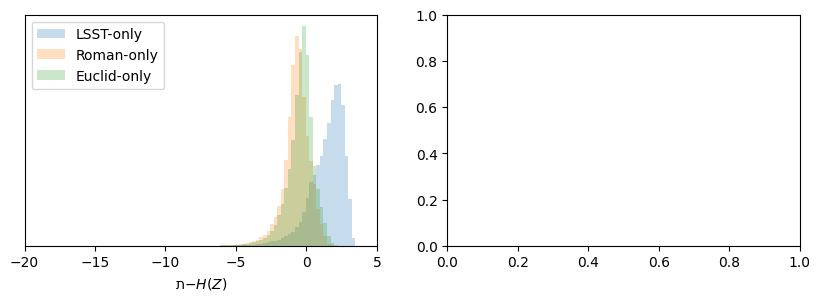

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))#, sharex=True)
delta_tav_agg = []
# which_plt = 0
# for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
#   ax[which_plt].hist(tav_cats[os]['z_true'], alpha=0.25, label=os[:-5], density=True, bins=100)
#   ax[which_plt].legend()
#   ax[which_plt].set_xlim(0, 5)
#   ax[which_plt].set_xlabel(r'$z$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   ax[which_plt].set_yticks([])
which_plt = 0
for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  ax[which_plt].hist(tav[os].mean(axis=1), alpha=0.25, label=os, density=True, bins=np.linspace(-20, 5, 100))
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-20, 5)
  ax[which_plt].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  ax[which_plt].set_yticks([])
which_plt = 1
for i, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  delta_tav_agg[i] = np.exp(tav[os].mean(axis=1)) * (tav[os].mean(axis=1) - delta_tav_agg[i])
  ax[which_plt].hist(delta_tav_agg[i], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 10, 100))
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-5, 10)
  ax[which_plt].set_xlabel('point-wise information gain') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  ax[which_plt].set_yticks([])


fig.show()

In [44]:
pd.merge(catalogs['LSST-only'], catalogs['Euclid+LSST'], on='CASTOR_ID')

,z_true_x,r_x,u-g_x,g-r_x,r-i_x,i-z_x,z-y_x,z_true_y,r_y,u-g_y,g-r_y,r-i_y,i-z_y,z-y_y,v,v-y,y-j,j-h
CASTOR_ID,,,,,,,,,,,,,,,,,,
3,0.2211,23.259175,0.388963,0.233539,0.022705,-0.005428,-0.064708,0.2211,23.259175,0.388963,0.233539,0.022705,-0.005428,-0.064708,23.203628,-0.016871,-0.121814,-0.055555
12,0.7070,24.580852,-0.101902,0.256711,0.638455,0.055040,-0.005697,0.7070,24.580852,-0.101902,0.256711,0.638455,0.055040,-0.005697,24.190875,0.605677,-0.100641,0.005671
73,0.4290,22.664345,0.406684,0.849034,0.207854,0.116569,0.161528,0.4290,22.664345,0.406684,0.849034,0.207854,0.116569,0.161528,22.541518,0.458337,0.157455,-0.027302
74,1.5087,23.744620,0.176465,0.068058,0.050240,-0.009388,0.407905,1.5087,23.744620,0.176465,0.068058,0.050240,-0.009388,0.407905,23.728690,0.578910,0.169981,-0.051920
85,1.0800,24.119466,0.148883,0.139313,0.230962,0.423380,0.217320,1.0800,24.119466,0.148883,0.139313,0.230962,0.423380,0.217320,23.861097,0.725771,0.061637,-0.011445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964423,0.9026,23.874750,0.393508,0.594628,0.971716,0.558262,0.173792,0.9026,23.874750,0.393508,0.594628,0.971716,0.558262,0.173792,23.098966,1.128346,0.500891,0.396050
964424,0.3275,20.315891,1.715947,1.310021,0.486272,0.266220,0.238608,0.3275,20.315891,1.715947,1.310021,0.486272,0.266220,0.238608,20.022624,0.880555,0.322735,0.060411
964426,0.3230,23.775628,0.670550,0.738462,0.247866,0.226397,0.192344,0.3230,23.775628,0.670550,0.738462,0.247866,0.226397,0.192344,23.598673,0.501241,0.117568,0.082705


In [41]:
catalogs['LSST-only'].join(catalogs['Euclid+LSST'], )

{'LSST-only':            z_true          r       u-g       g-r       r-i       i-z       z-y
 CASTOR_ID                                                                     
 3          0.2211  23.259175  0.388963  0.233539  0.022705 -0.005428 -0.064708
 12         0.7070  24.580852 -0.101902  0.256711  0.638455  0.055040 -0.005697
 73         0.4290  22.664345  0.406684  0.849034  0.207854  0.116569  0.161528
 74         1.5087  23.744620  0.176465  0.068058  0.050240 -0.009388  0.407905
 85         1.0800  24.119466  0.148883  0.139313  0.230962  0.423380  0.217320
 ...           ...        ...       ...       ...       ...       ...       ...
 964426     0.3230  23.775628  0.670550  0.738462  0.247866  0.226397  0.192344
 964428     1.2587  23.131750  0.301321  0.215503  0.278632  0.447965  0.140599
 964429     0.5593  23.418713 -0.136808  0.127887  0.138505 -0.061029  0.064696
 964439     0.3207  24.778841  0.223926  0.566495  0.228750  0.012524 -0.129905
 964449     0.3073  24.7928

In [38]:
import scipy.stats as sps

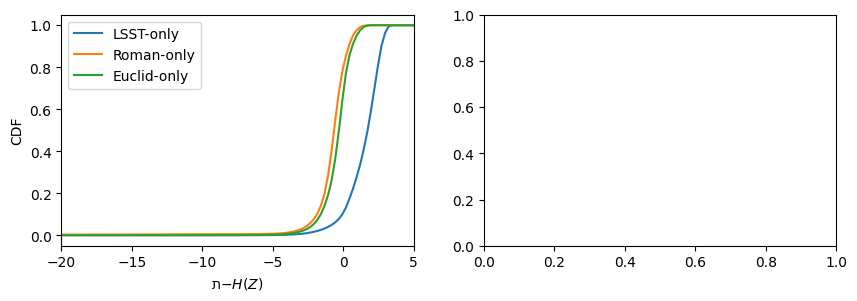

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))#, sharex=True)
delta_tav_agg = []
# which_plt = 0
# for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
#   ax[which_plt].hist(tav_cats[os]['z_true'], alpha=0.25, label=os[:-5], density=True, bins=100)
#   ax[which_plt].legend()
#   ax[which_plt].set_xlim(0, 5)
#   ax[which_plt].set_xlabel(r'$z$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   ax[which_plt].set_yticks([])
which_plt = 0
for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  xran = np.linspace(-20, 5, 100)
  to_plot = sps.ecdf(tav[os].mean(axis=1)).cdf.evaluate(xran)
  ax[which_plt].plot(xran, to_plot, label=os)
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-20, 5)
  ax[which_plt].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  # ax[which_plt].set_yticks([])
  ax[which_plt].set_ylabel('CDF')
which_plt = 1
for i, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  delta_tav_agg[i] = np.exp(just_tav[os]) * (just_tav[os] - delta_tav_agg[i])
  xran = np.linspace(-5, 10, 100)
  to_plot = sps.ecdf(delta_tav_agg[i][np.isfinite(delta_tav_agg[i])]).cdf.evaluate(xran)
  ax[which_plt].plot(xran, to_plot, label=os)
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-5, 10)
  ax[which_plt].set_xlabel('point-wise information gain') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  # ax[which_plt].set_yticks([])
  ax[which_plt].set_ylabel('CDF')

fig.show()

In [34]:
len(tav['LSST-only'].mean(axis=1))

116127

In [1]:
tav[os]

NameError: name 'tav' is not defined

In [ ]:
LSST_os = ['LSST-only',
           'LSST+CASTOR',
           'Euclid+LSST',
           'Roman+LSST']

Roman_os = ['Roman-only',
            'Euclid+Roman',
            'Roman+LSST',
            'Roman+CASTOR']

CASTOR_os = ['CASTOR-only',
             'Euclid+CASTOR',
             'LSST+CASTOR',
             'Roman+CASTOR']

Euclid_os = ['Euclid-only',
             'Euclid+Roman',
             'Euclid+CASTOR',
             'Euclid+LSST']

LSST-only
0
-1.0256441732872812
LSST+CASTOR
0
4.9317021291424e-310
Euclid+LSST
0
1.848524808883667
Roman+LSST
0
0.000294774478668394
Roman-only
0
0.0
Euclid+Roman
0
0.000294774478668394
Roman+LSST
0
0.000294774478668394
Roman+CASTOR
0
6.73319350615775e-310
CASTOR-only
0
-0.40575724840164185
Euclid+CASTOR
0
0.0
LSST+CASTOR
0
4.9317021291424e-310
Roman+CASTOR
0
6.73319350615775e-310
Euclid-only
0
-0.18921197950839996
Euclid+Roman
0
0.000294774478668394
Euclid+CASTOR
0
0.0
Euclid+LSST
0
1.848524808883667


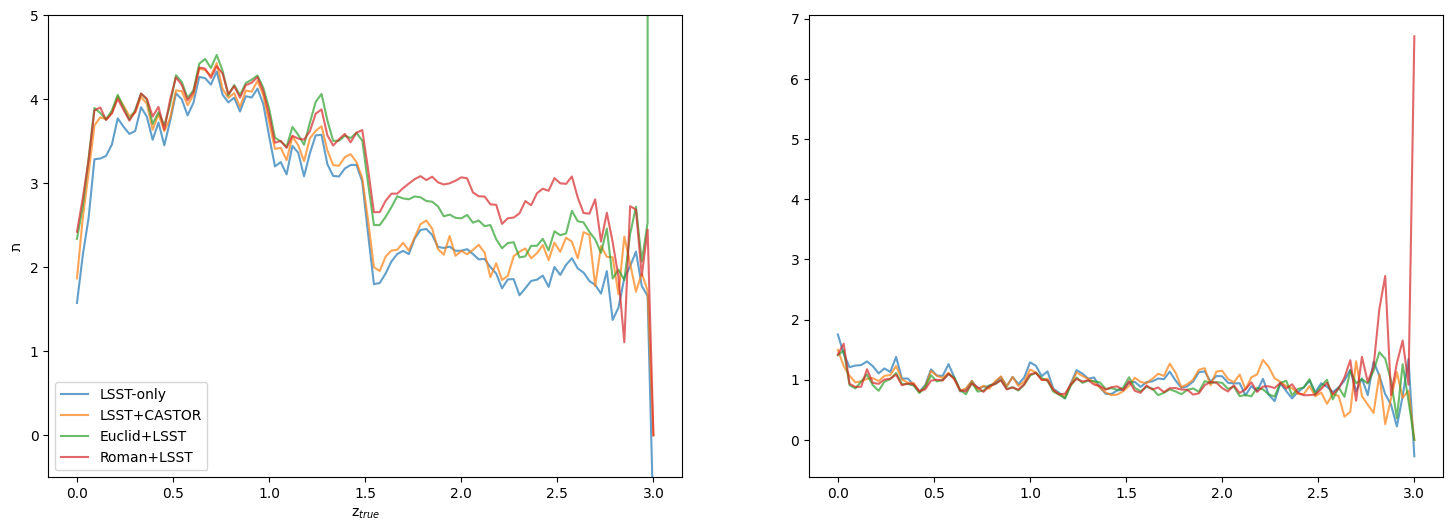

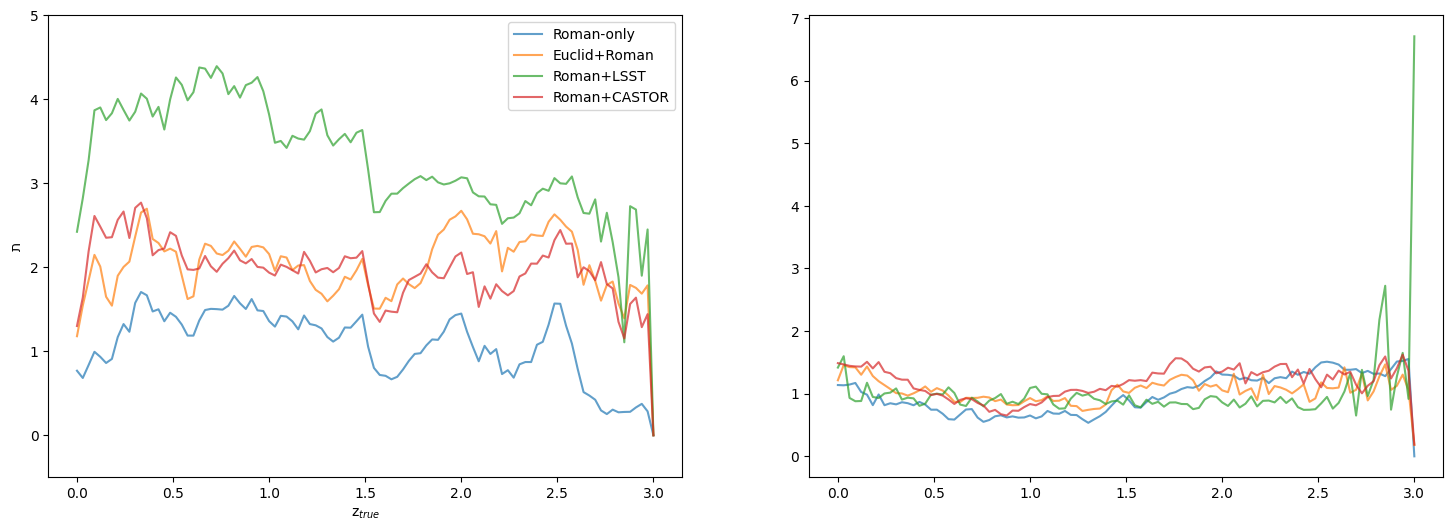

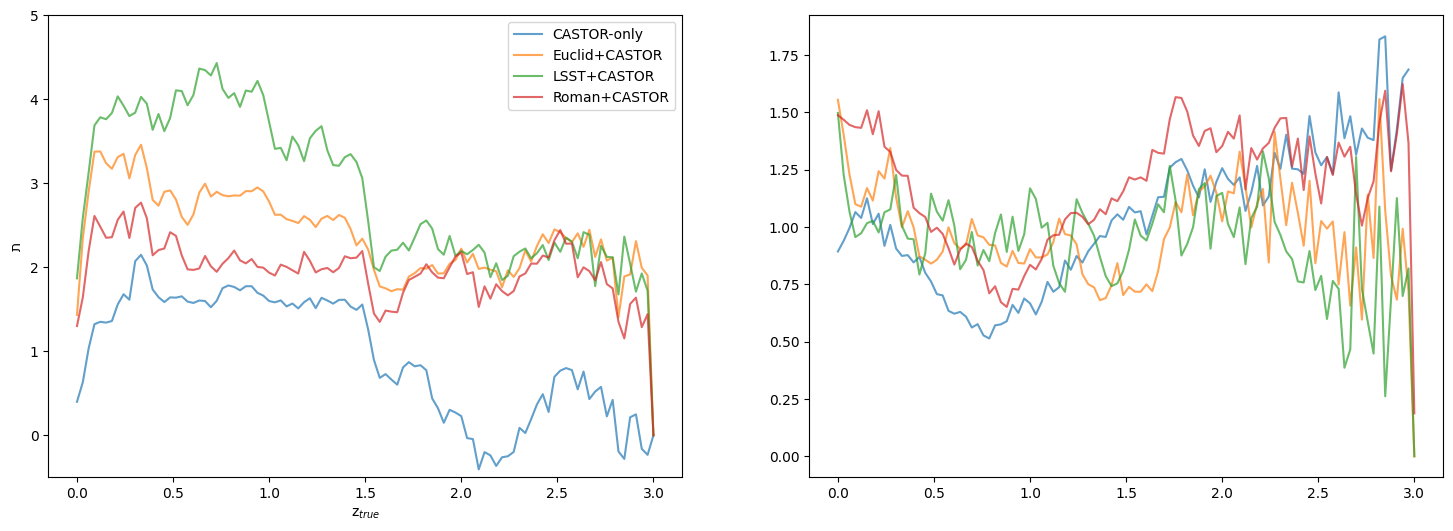

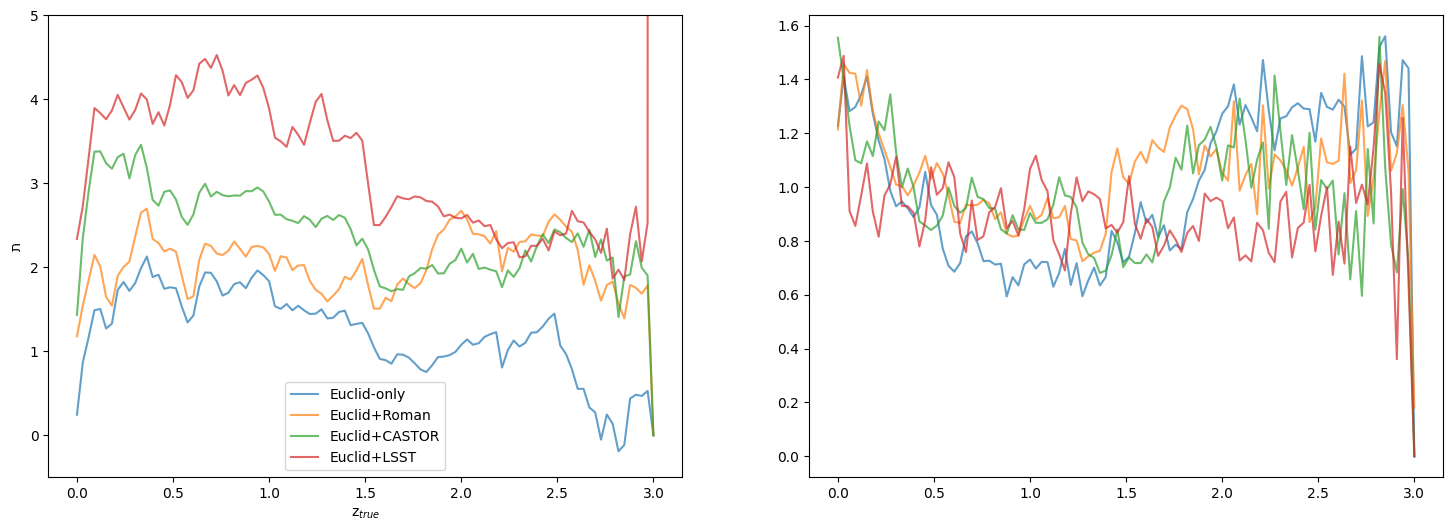

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in LSST_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in Roman_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()


fig, ax = plt.subplots(1, 2, figsize = (18, 6))


for os in CASTOR_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))


for os in Euclid_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

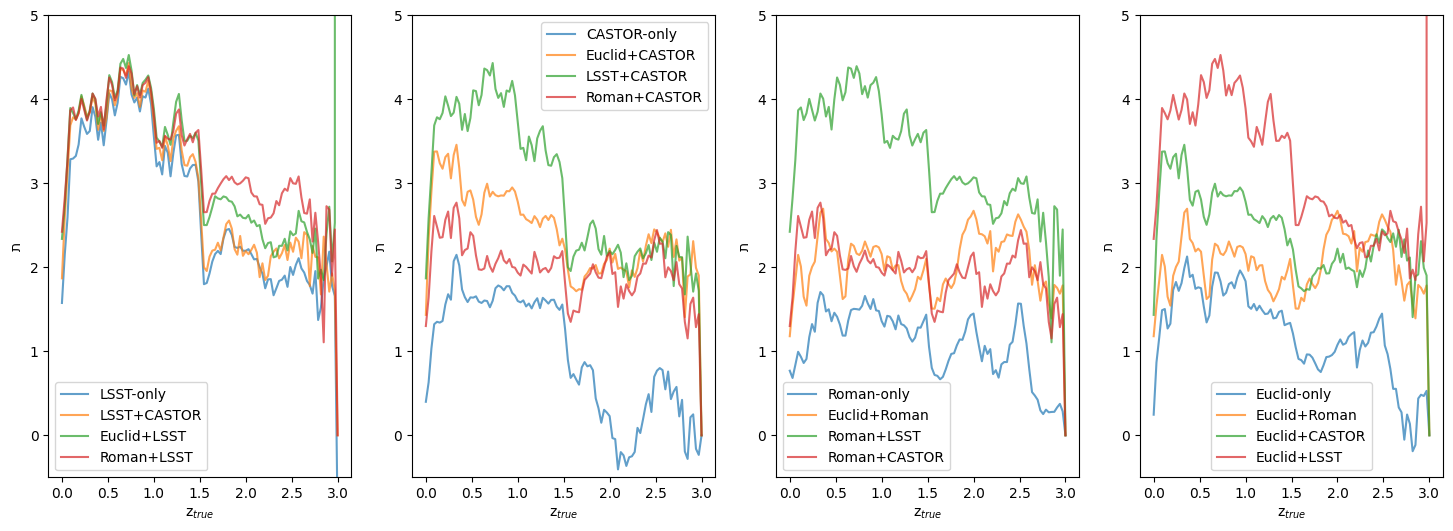

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in LSST_os:
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)

for os in Roman_os:
  ax[2].plot(zbins, avgtav[os], label=os, alpha=0.7)

for os in CASTOR_os:
  ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

for os in Euclid_os:
  ax[3].plot(zbins, avgtav[os], label=os, alpha=0.7)


ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-0.5, 5)
ax[1].legend()

ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylabel(chr(0x05ea))
ax[2].set_ylim(-0.5, 5)
ax[2].legend()

ax[3].set_xlabel('z$_{true}$')
ax[3].set_ylabel(chr(0x05ea))
ax[3].set_ylim(-0.5, 5)
ax[3].legend()

In [ ]:
available_os

['LSST-only',
 'CASTOR-only',
 'Roman-only',
 'Euclid-only',
 'LSST+CASTOR',
 'Euclid+CASTOR',
 'Roman+CASTOR',
 'Euclid+LSST',
 'Roman+LSST',
 'Euclid+Roman',
 'Roman+LSST+CASTOR',
 'Roman+Euclid+CASTOR',
 'Euclid+LSST+CASTOR',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

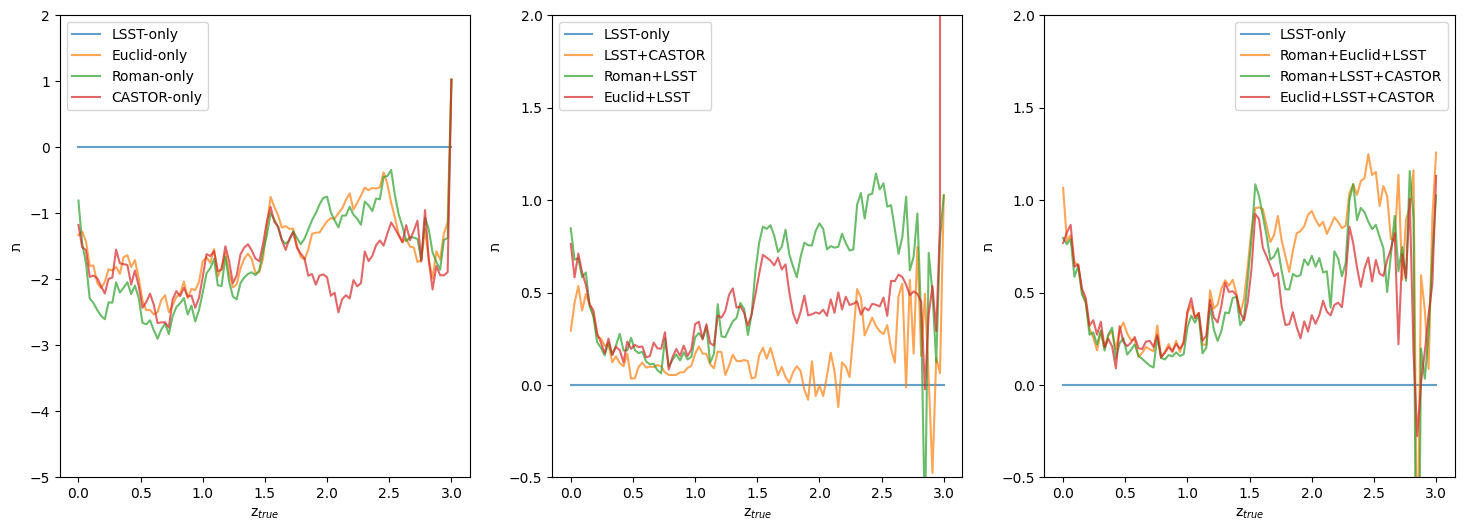

In [ ]:
single_os = ['LSST-only',
                 'Euclid-only',
                 'Roman-only',
                 'CASTOR-only']

two_os = ['LSST-only',
          'LSST+CASTOR',
          'Roman+LSST',
          'Euclid+LSST']

three_os = ['LSST-only',
            'Roman+Euclid+LSST',
            'Roman+LSST+CASTOR',
            'Euclid+LSST+CASTOR']

fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in single_os:
  ax[0].plot(zbins, avgtav[os] - avgtav['LSST-only'], label=os, alpha=0.7)

for os in two_os:
  ax[1].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


for os in three_os:
  ax[2].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-5, 2)
ax[0].legend()

ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-0.5, 2)
ax[1].legend()

ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylabel(chr(0x05ea))
ax[2].set_ylim(-0.5, 2)
ax[2].legend()



In [ ]:
print(catalogs['LSST-only'].describe())
print(catalogs['CASTOR-only'].describe())
print(catalogs['Euclid-only'].describe())
print(catalogs['Roman-only'].describe())

             z_true             r           u-g           g-r           r-i  \
count  93451.000000  93451.000000  93451.000000  93451.000000  93451.000000   
mean       0.930896     23.803721      0.344776      0.411073      0.360304   
std        0.477202      0.921701      0.285975      0.320774      0.244005   
min        0.020100     21.153990     -1.401706     -0.799049     -0.530725   
25%        0.581700     23.250825      0.156767      0.160481      0.163317   
50%        0.888500     23.961852      0.279376      0.320017      0.312153   
75%        1.234000     24.503052      0.465536      0.629880      0.549052   
max        3.005400     25.836993      2.433796      1.691936      1.444229   

                i-z           z-y       logprob  
count  93451.000000  93451.000000  93451.000000  
mean       0.251419      0.196281      3.633287  
std        0.201112      0.168104      1.122307  
min       -0.833481     -0.990875     -9.084731  
25%        0.100961      0.094918     

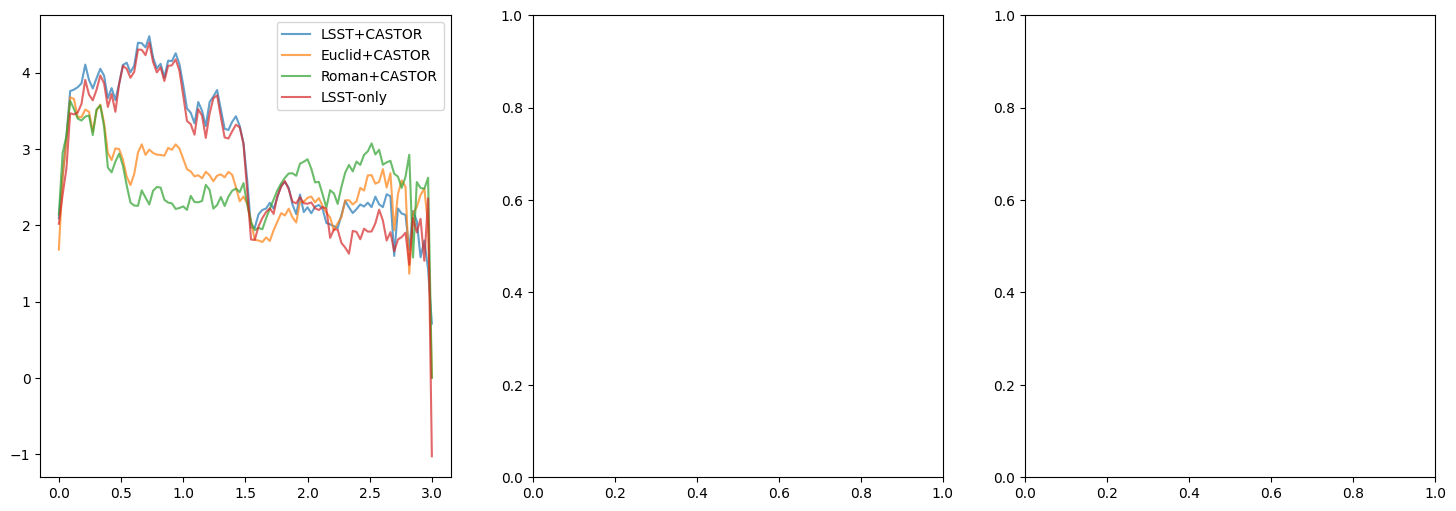

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)

for os in available_os[4:7]+['LSST-only']:
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
ax[0].legend()

In [ ]:
catalogs['LSST-only'].describe()
catalogs['Euclid-only'].describe()

,z_true,v,v-y,y-j,j-h,logprob
count,356137.000000,356137.000000,356137.000000,356137.000000,356137.000000,356137.000000
mean,1.122987,25.119202,0.612206,0.221261,0.090340,0.890590
std,0.680365,1.325200,0.545003,0.489644,0.469145,1.387285
min,0.020100,20.892275,-1.569294,-1.972598,-1.992058,-18.072918
25%,0.616500,24.296269,0.322861,0.003146,-0.109406,0.391334
50%,0.994400,25.317732,0.628364,0.199739,0.099996,1.211732
75%,1.479300,26.125797,0.930113,0.422974,0.322571,1.730352
max,3.454200,29.281030,2.669016,2.449276,2.169130,4.512432


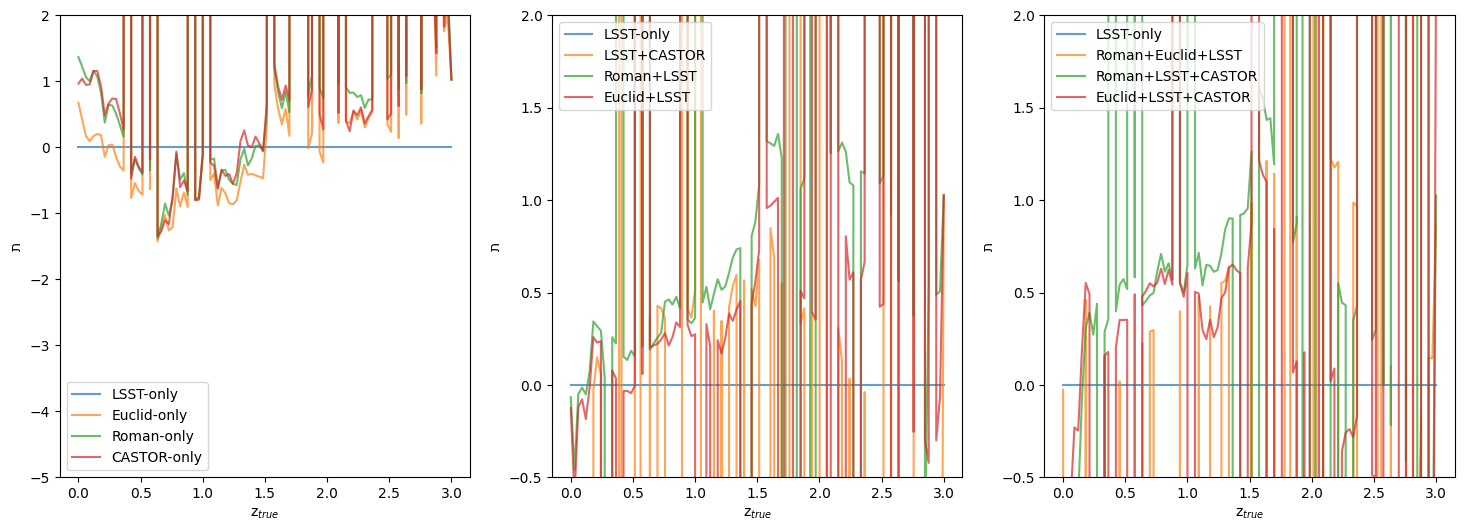

In [ ]:
single_os = ['LSST-only',
                 'Euclid-only',
                 'Roman-only',
                 'CASTOR-only']

two_os = ['LSST-only',
          'LSST+CASTOR',
          'Roman+LSST',
          'Euclid+LSST']

three_os = ['LSST-only',
            'Roman+Euclid+LSST',
            'Roman+LSST+CASTOR',
            'Euclid+LSST+CASTOR']

fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in single_os:
  ax[0].plot(zbins, avgtav[os] - avgtav['LSST-only'], label=os, alpha=0.7)

for os in two_os:
  ax[1].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


for os in three_os:
  ax[2].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-5, 2)
ax[0].legend()

ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-0.5, 2)
ax[1].legend()

ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylabel(chr(0x05ea))
ax[2].set_ylim(-0.5, 2)
ax[2].legend()

In [ ]:
def compute_milb_ensemble(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = all_milb[os] + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    # all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [ ]:
all_tlm, is_inf_mask = compute_milb_ensemble(new_tav, available_os)


['LSST-only', 'CASTOR-only', 'Euclid+LSST', 'LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR']


<ipython-input-55-2c69b1faeef8>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [ ]:
np.shape(all_tlm['LSST-only'])

(108330, 27)

In [ ]:
type(all_tlm['LSST-only'])

numpy.ndarray

In [36]:
import numpy.ma as ma

In [37]:
epistemic_variance = {}
redshifts = {}

for os in available_os:
  epistemic_variance[os] = ma.array(all_tlm[os], mask = ~(np.abs(all_tlm[os]) < 100)).std(axis=1).data
  redshifts[os] = ma.array(catalogs[os]['z_true'], mask = ~(np.abs(all_tlm[os].mean()) < 100)).data

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
binned_variance = {}

for os in available_os:
  print(epistemic_variance[os].shape)
  print(redshifts[os].shape)

  ploterr = np.empty_like(zbins)
  for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      ploterr[i] = np.mean(epistemic_variance[os][(redshifts[os] >=zmin) & (redshifts[os] < zmax)])

      binned_variance[os] = ploterr



(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)


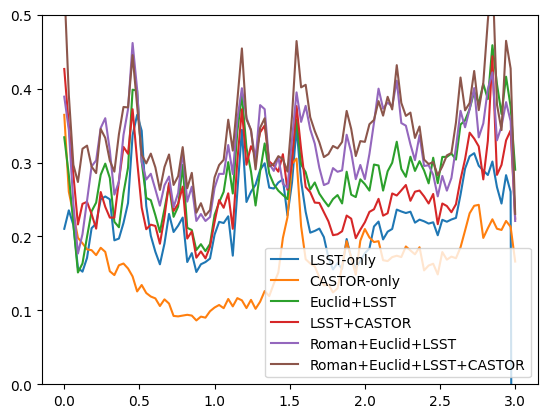

In [ ]:
for os in available_os:
  plt.plot(zbins, binned_variance[os], label = os)
  plt.ylim(0, 0.5)

  plt.legend()

possibly a consequence of weird values in the catalogs --> more surveys compounds this effect. "Mo surveys, mo problems" - Alex Malz

different surveys use different placeholders for bad values --> as you combine surveys, how many notions --> value of bad values --> coherent surveys, how do notions of bad values impact survey metrics --> good sample size gets smaller with more surveys

In [ ]:
redshifts['LSST-only'].shape

(430635,)

In [ ]:
a = np.array(catalogs[os]['z_true'])

In [ ]:
np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1)

(430635, 27)

In [ ]:

for os in available_os:
    ploterr = np.empty_like(zbins)
    # catalogs[os] = catalogs[os][(np.abs(all_tlm[os]) < 100)]

    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      # subset = epistemic_variance[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]

      subset = ma.array(all_tlm[os], mask = ~(np.abs(all_tlm[os]) < 100) & (np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1) >= zmin) & (np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1) < zmax)).std(axis=1).data

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ValueError: operands could not be broadcast together with shapes (430635,26) (430635,27) 

In [ ]:
def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = epistemic_variance
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]
      print(catalogs[os].columns)

      print('shape is: ')

      print(np.shape(catalogs[os]))
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(vals[vals >   -3])
      # print(mean)
      std = np.std(vals[vals > -3])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

(430635,)

In [ ]:
A = np.array([[1, 2], [3, np.inf]])
A

~np.isfinite(all_tlm['LSST-only']) & (np.abs(all_tlm['LSST-only']) < 100)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
ma.array(A, mask = ~np.isfinite(A)).std()

0.816496580927726

In [ ]:
import numpy.ma as ma

In [ ]:
def compute_milb_stats(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  new_tlm = {}
  std_tlm = {}

  print(available_os)

  for os in available_os:

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy

    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]

    print(np.shape(milb))


    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb + entropy

    standards = []

    for i in range(0, np.shape(all_tlm[os])[1]):

      standards.append(np.std(all_tlm[os][:,i][np.isfinite(all_tlm[os][:,i])]))

      std_tlm[os] = standards

    # all_tlm_std = all_tlm[os].std(axis=1, where = ~np.isinf(all_tlm[os]))

  return std_tlm

In [ ]:

std_tlm = compute_milb_stats(new_tav, available_os)


['LSST-only', 'CASTOR-only', 'Euclid+LSST', 'LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR']
(430635, 27)


<ipython-input-359-c1c8f712d9b6>:18: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


(430635, 27)
(430635, 26)
(430635, 28)
(430635, 25)
(430635, 28)


In [ ]:
std_tlm['LSST-only']

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [ ]:
np.max(all_tlm_std)

inf

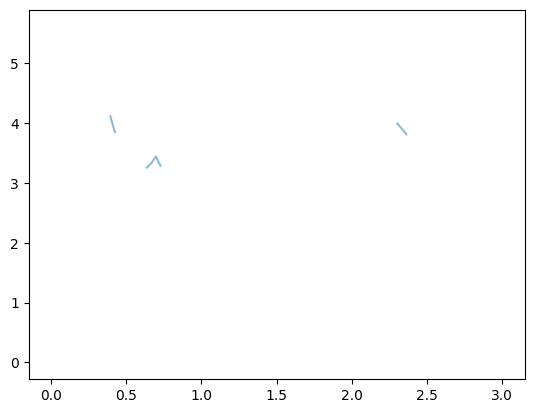

In [ ]:
for os in available_os:
  vals = np.zeros_like(zbins)

  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]

    subset = all_tlm_std[(z_true > zmin) & (z_true < zmax)]
    vals[i] = np.mean(subset)

plt.plot(zbins, vals, label=os, alpha=0.5)


In [ ]:
vals

array([5.61689091,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
       4.29682207,        inf,        inf, 4.11501408, 3.84934044,
              inf,        inf,        inf,        inf,        inf,
              inf, 3.25604939, 3.33084249, 3.44355536, 3.28679085,
              inf,        inf, 3.36345959,        inf,        inf,
       3.04792452,        inf,        inf,        inf,        inf,
       3.72727346,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf, 3.65883517,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf, 4.26099634,        

In [ ]:
def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]
      print(catalogs[os].columns)

      print('shape is: ')

      print(np.shape(catalogs[os]))
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(vals[vals >   -3])
      # print(mean)
      std = np.std(vals[vals > -3])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [ ]:
np.shape(all_tlm_le['LSST-only'])

(318745,)

In [ ]:
drops = ['drop_uv', 'drop_u', 'drop_g']

In [ ]:
flows_drops = {}
flows_drops['drop_uv'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_uv.pkl")
flows_drops['drop_u'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_u.pkl")
flows_drops['drop_g'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_g.pkl")

In [ ]:
catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'uv': CASTOR_uv_mag,
                              'u':   CASTOR_u_mag,
                             'g': CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()

In [ ]:
just_tav_drops = {}

just_tav_drops['drop_uv'] = flows_drops['drop_uv'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_u'] = flows_drops['drop_u'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_g'] = flows_drops['drop_g'].log_prob(catalogs['LSST+CASTOR'])

In [ ]:
all_tlm, is_inf_mask = compute_milb(just_tav_drops, drops)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

['drop_uv', 'drop_u', 'drop_g']


KeyError: 'drop_uv'

In [ ]:
all_tlm[available_os[1]].shape

KeyError: 'CASTOR-only'

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for os in available_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.5)
  ax[0].fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z_true')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-1, 5)